# ECCITE 1D Analysis

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm

import os
import pickle as pkl
%matplotlib inline

In [2]:
pd.set_option('max_columns', None)
pd.set_option('display.max_rows', 500)

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'axes.labelsize': 'large'}
pylab.rcParams.update(params)

In [5]:
data_path = '/data_volume/memento/eccite/'

### Read the guide labled perturb-seq data

From perturbseq paper

In [6]:
adata = sc.read(data_path + 'eccite.h5ad')
adata.var.index.name=None

In [7]:
adata.obs['gene'].value_counts()

NT          3393
IFNGR1      3076
IFNGR2      1672
CD86        1654
ETV7        1338
IRF7        1323
JAK2        1230
PDCD1LG2    1227
ATF2        1221
IRF1        1159
MARCH8      1157
TNFRSF14    1076
CMTM6       1002
CAV1         991
NFKBIA       943
POU2F2       894
STAT5A       854
STAT3        739
STAT2        736
SMAD4        734
UBE2L6       647
STAT1        458
BRD4         364
CUL3         277
MYC          115
SPI1          56
PDL1          10
Name: gene, dtype: int64

In [8]:
adata.obs.head(2)

,lane,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,orig.ident,nCount_HTO,nFeature_HTO,MULTI_ID,MULTI_classification,replicate,treatment,guide_ID,second_percent,gene
GATCGATGTAACGACG-2,2,4695,20006.0,1006.0,5.028491,SeuratProject,258,8,rep4-tx-TCGATAATGCGA,rep4-tx-TCGATAATGCGA,rep4,tx,IFNGR1g2-CTTTCTGATATCCAGTTTA,0.003125,IFNGR1
AACTCTTCAAGTTCTG-3,3,3789,15422.0,596.0,3.864609,SeuratProject,190,6,rep4-tx-TCGATAATGCGA,rep4-tx-TCGATAATGCGA,rep4,tx,IFNGR1g2-CTTTCTGATATCCAGTTTA,0.007979,IFNGR1


In [9]:
adata.obs['treatment'].value_counts()

tx      25460
ctrl     2886
Name: treatment, dtype: int64

### Read pre-defined ISGs

In [10]:
isg_classes = pd.read_csv('isg_classes.csv')

In [11]:
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()

### Setup memento

In [12]:
adata.obs['q'] = 0.15

In [13]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07 ,trim_percent=0.05)

Version 0.0.6


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:70: RankWarning: Polyfit may be poorly conditioned


In [14]:
ko_genes = adata.obs.gene.drop_duplicates().tolist()

### Memento - WT vs KO

In [14]:
for treatment in ['ctrl', 'tx']:
    for g in ko_genes:

        if g == 'NT':
            continue

        subset = adata[adata.obs['gene'].isin(['NT', g]) & (adata.obs['treatment']==treatment)].copy().copy()

        subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).values
        
        memento.create_groups(subset, label_columns=['is_ko', 'replicate'])

        memento.compute_1d_moments(subset, min_perc_group=.7)

        memento.ht_1d_moments(
            subset, 
            formula_like='1 + is_ko + replicate',
            treatment_col='is_ko', 
            num_boot=10000, 
            verbose=1,
            resampling='permutation',
            approx=False,
            num_cpus=94)

        subset.write(data_path + '1d/{}_{}.h5ad'.format(g, treatment)) 


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:    5.1s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:    7.4s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:    9.8s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:   12.7s
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:   16.2s
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:   20.3s
[Parallel(n_jobs=94)]: Done 3862 tasks      | elapsed:   24.8s
[Parallel(n_jobs=94)]: Done 4812 tasks      | elapsed:   30.0s
[Parallel(n_jobs=94)]: Done 5862 tasks      | elapsed:   35.5s
[Parallel(n_j

In [15]:
for treatment in ['ctrl', 'tx']:
    for g in ko_genes:

        if g == 'NT':
            continue

        subset = adata[adata.obs['gene'].isin(['NT', g]) & (adata.obs['treatment']==treatment)].copy().copy()

        subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).values
        
        memento.create_groups(subset, label_columns=['is_ko', 'replicate', 'guide_ID'])

        memento.compute_1d_moments(subset, min_perc_group=.7)

        memento.ht_1d_moments(
            subset, 
            formula_like='1 + is_ko + replicate',
            treatment_col='is_ko', 
            num_boot=10000, 
            verbose=1,
            resampling='bootstrap',
            approx=False,
            num_cpus=94)

        subset.write(data_path + '1d/{}_{}_guide_rep.h5ad'.format(g, treatment)) 


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:    2.9s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:    6.4s
[Parallel(n_jobs=94)]: Done 826 out of 826 | elapsed:    8.4s finished
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 

### Memento - ctrl vs stim

In [24]:
subset = adata[adata.obs['gene'].isin(['NT'])].copy().copy()

subset.obs['is_stim'] = (subset.obs['treatment'] == 'tx').astype(int)

memento.create_groups(subset, label_columns=['is_stim', 'replicate'])

memento.compute_1d_moments(subset, min_perc_group=.7)

memento.ht_1d_moments(
    subset, 
    formula_like='1 + is_stim + replicate',
    treatment_col='is_stim', 
    num_boot=10000, 
    verbose=1,
    resampling='permutation',
    approx=False,
    num_cpus=94)



/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.4s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:    7.2s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   11.4s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   16.6s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:   22.2s
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:   28.7s
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:   36.9s
[Parallel(n_jobs=94)]: Done 3862 tasks      | elapsed:   45.9s
[Parallel(n_jobs=94)]: Done 4812 tasks      | elapsed:   55.5s
[Parallel(n_jobs=94)]: Done 5862 tasks      | elapsed:  1.1min
[Parallel(n_j

In [25]:
stim_ht_df = memento.get_1d_ht_result(subset)
stim_ht_df['de_fdr'] = memento.util._fdrcorrect(stim_ht_df['de_pval'])

In [26]:
thp1_isgs = stim_ht_df.query('de_fdr < 0.05 & de_coef > 1').gene.tolist()

### Analyze 1D - ctrl

In [27]:
results = {}
moments = {}
for treatment in ['ctrl', 'tx']:
    results[treatment] = {}
    moments[treatment] = {}
    for g in ['STAT1']:#ko_genes:
    #     print(g)
        if g == 'NT': continue
        subset = sc.read(data_path +'1d/{}_{}.h5ad'.format(g, treatment))
        df = memento.get_1d_ht_result(subset)
        df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
        df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
        moment_df = memento.get_1d_moments(subset, groupby='is_ko')
        results[treatment][g] = df.copy()
        moments[treatment][g] = (moment_df[0].copy(), moment_df[1].copy())

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log


In [28]:
moment_df = moments['ctrl'][g]

In [35]:
moment_df = moments['ctrl']['STAT1']
ctrl_df = pd.melt(moment_df[1][moment_df[1]['gene'].isin(set(thp1_isgs) & set(t1_isg))], id_vars=['gene'])
ctrl_df['stim'] = 'CTRL'
moment_df = moments['tx']['STAT1']
stim_df = pd.melt(moment_df[1][moment_df[1]['gene'].isin(set(thp1_isgs) & set(t1_isg))], id_vars=['gene'])
stim_df['stim'] = 'IFNG'

In [36]:
combined_df = pd.concat([ctrl_df, stim_df])

In [37]:
combined_df.head(5)

,gene,variable,value,stim
0,ISG15,is_ko_False,2.014224,CTRL
1,IFI6,is_ko_False,2.749943,CTRL
2,MTMR11,is_ko_False,0.879598,CTRL
3,IFI16,is_ko_False,1.361764,CTRL
4,CMPK2,is_ko_False,1.513613,CTRL


In [38]:
combined_df['KO'] = (combined_df['variable']=='is_ko_True')

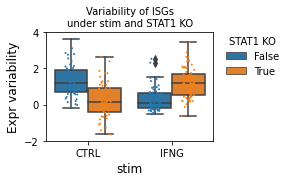

In [40]:
plt.figure(figsize=(3,2))
sns.boxplot(x='stim', y='value', hue='KO', data=combined_df)

ax = sns.stripplot(x='stim', y='value', hue='KO', data=combined_df, lw=1,dodge=True, jitter=0.15, size=2)
handles, labels = ax.get_legend_handles_labels()
plt.ylim(-2, 4)
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='STAT1 KO', frameon=False)
plt.title('Variability of ISGs\nunder stim and STAT1 KO')
plt.ylabel('Expr variability')
plt.savefig('ko_variability.png', bbox_inches='tight', dpi=1000)

In [27]:
# for g in ko_genes:
#     print(g, results[g].query('de_fdr < 0.1').shape[0],results[g].query('dv_fdr < 0.1').shape[0])

In [33]:
df['de_fdr'].min()

0.011924324558855231

In [46]:
df[df['gene'].isin(t1_isg)]

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
1,ISG15,-0.880896,0.479676,0.066697,-2.574134,1.084285,0.050491,0.869292,0.972911
78,ID3,-0.061514,0.222635,0.784868,-0.684816,0.411524,0.097263,0.988835,0.972911
112,IFI6,-0.890872,0.284246,0.001780,-3.368115,0.722215,0.000189,0.515849,0.271196
338,SLC16A1-AS1,-0.289564,0.351329,0.421529,-0.791667,0.696449,0.362076,0.930839,0.972911
376,MTMR11,-0.171136,0.250006,0.508200,-0.003476,0.541431,0.994884,0.957807,0.999970
426,ADAR,-0.277844,0.170796,0.111153,0.266803,0.617828,0.666404,0.904364,0.975958
461,IFI16,0.341682,0.336636,0.315423,-0.275317,0.512825,0.595555,0.916560,0.972911
503,ANKRD45,-0.136893,0.392443,0.730709,0.297412,0.865797,0.741612,0.984240,0.980984
564,IKBKE,-0.182884,0.281758,0.530269,-0.119364,0.808990,0.885319,0.957807,0.993753
593,DEGS1,-0.180495,0.190626,0.350117,-0.612472,0.635888,0.494652,0.916560,0.972911


In [40]:
df[df['gene'].str.contains('IFI')]

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
112,IFI6,-0.890872,0.284246,0.001780,-3.368115,0.722215,0.000189,0.515849,0.271196
461,IFI16,0.341682,0.336636,0.315423,-0.275317,0.512825,0.595555,0.916560,0.972911
883,IFIH1,0.241137,0.366401,0.510500,-0.672634,0.660225,0.406476,0.957807,0.972911
2953,IFITM1,-0.393704,0.292996,0.187282,-1.282270,0.692037,0.219851,0.908332,0.972911
3805,IFI27L1,-0.970164,0.299815,0.002009,0.586259,0.740287,0.468852,0.515849,0.972911
3806,IFI27,-1.008181,0.477425,0.034720,-3.391881,0.846185,0.001247,0.866801,0.583332
3807,IFI27L2,0.025204,0.170008,0.884753,0.274172,0.490449,0.576914,0.995320,0.972911
4422,IFI35,-0.421358,0.328377,0.213563,-0.878804,0.649577,0.369787,0.908332,0.972911
4838,IFI30,-0.207084,0.301408,0.496475,-1.648692,0.493448,0.001013,0.957056,0.517082


In [34]:
df.query('de_fdr < 0.2')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
87,SRRM1,-0.617255,0.149019,0.000048,0.116679,0.472580,0.809410,0.066959,0.984587
114,PPP1R8,-1.407064,0.332672,0.000026,-1.169531,0.707794,0.353657,0.047784,0.972911
475,USP21,-1.118653,0.260988,0.000179,-1.266985,0.743265,0.485916,0.108681,0.972911
1706,DIAPH1,-0.812993,0.213911,0.000194,1.045969,0.571545,0.067239,0.108681,0.972911
1946,BAG2,-1.306487,0.345063,0.000169,-0.177631,0.588407,0.790003,0.108681,0.982497
2300,METTL2B,-1.320267,0.318968,0.000257,-0.005663,0.765986,0.994112,0.123770,0.999970
2397,ESCO2,-1.753447,0.334480,0.000002,-0.464108,0.546318,0.439907,0.011924,0.972911
2457,ARFGEF1,-1.157865,0.317034,0.000265,-1.403745,0.770913,0.260313,0.123770,0.972911
3160,CDK2AP2,-0.863801,0.225982,0.000159,-1.173736,0.628085,0.064423,0.108681,0.972911
3803,UBR7,-1.284805,0.287789,0.000086,-0.591168,0.736786,0.504380,0.096134,0.972911


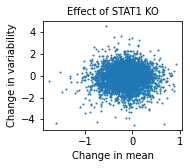

In [29]:
tf = 'STAT1'
plt.figure(figsize=(2.5,2))
plt.scatter(results[tf]['de_coef'], results[tf]['dv_coef'], s=1)
plt.title('Effect of {} KO'.format(tf));
plt.xlabel('Change in mean'); plt.ylabel('Change in variability')
plt.scatter(results[tf].query('dv_fdr < 0.1 & dv_coef > 0')['de_coef'], results[tf].query('dv_fdr < 0.1 & dv_coef > 0')['dv_coef'], s=5)
plt.scatter(results[tf].query('dv_fdr < 0.1 & dv_coef < 0')['de_coef'], results[tf].query('dv_fdr < 0.1 & dv_coef < 0')['dv_coef'], s=5)

# plt.savefig('figures/variability_{}.png'.format(tf), bbox_inches='tight', dpi=800)

In [ ]:
plt.figure(figsize=(2.5,2))
plt.scatter(results['STAT1']['de_coef'], results['STAT1']['dv_coef'], s=0.1)
plt.title('Effect of STAT1 KO');
plt.xlabel('Change in mean'); plt.ylabel('Change in variability')
plt.scatter(results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0')['de_coef'], results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0')['dv_coef'], s=1)
# plt.savefig('figures/variability.png', bbox_inches='tight', dpi=800)

In [134]:
results['IFNGR1'].query('gene == "IFNGR1"')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
3183,IFNGR1,-0.150763,0.045791,0.001701,0.199772,0.201333,0.314369,0.006115,0.849193


### Run coexpression

In [ ]:
# subset_ko_genes = ['STAT1', 'STAT2', 'JAK2', 'CUL3', 'IFNGR1', 'IFNGR2', 'MYC', 'SMAD4']
done_files = os.listdir(data_path + '/2d/')
for g in ko_genes:
    
    for g_ko in ko_genes:
        print(g, g_ko)
        
        if g == g_ko or g == 'NT' or g_ko == 'NT': continue
        fname = '{}_with_{}_KO.h5ad'.format(g, g_ko)
#         if fname in done_files: continue
        
        subset = adata.copy().copy()

        subset = adata[adata.obs['gene'].isin(['NT', g_ko])].copy().copy()
    
        subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g_ko).values

        memento.create_groups(subset, label_columns=['is_ko', 'replicate', 'guide_ID'])

        memento.compute_1d_moments(subset, min_perc_group=.7)
        
        if g not in subset.var.index: continue

        available_genes = list(
            set(subset.var.index) & \
            set(results[g].query('de_coef < 0 & de_fdr < 0.1').gene.tolist()) & \
            set(results[g_ko].query('de_coef < 0 & de_fdr < 0.1').gene.tolist())
            )
        
        if len(available_genes) < 10: continue
        memento.compute_2d_moments(subset, list(itertools.product([g], available_genes))   )

        memento.ht_2d_moments( 
            subset, 
            formula_like='1 + is_ko + replicate',
            treatment_col='is_ko', 
            num_boot=10000, 
            verbose=1,
            num_cpus=94,
            resampling='bootstrap',
            approx=False)
        
        subset.write(data_path + '2d/{}_with_{}_KO_guide_rep.h5ad'.format(g, g_ko))

### Check TF's correlation to other genes following KO

In [123]:
# subset_ko_genes = ['STAT1', 'STAT2', 'JAK2', 'CUL3', 'IFNGR1', 'IFNGR2', 'MYC', 'SMAD4']
done_files = os.listdir(data_path + '/2d/')
for g in ['JAK2']:#ko_genes:
    
    if g == 'NT': continue
    fname = '{}_with_{}_KO_guide_rep.h5ad'.format(g, g)
#         if fname in done_files: continue

    subset = adata.copy().copy()

    subset = adata[adata.obs['gene'].isin(['NT', g])].copy().copy()

    subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).values

    memento.create_groups(subset, label_columns=['is_ko', 'replicate', 'guide_ID'])

    memento.compute_1d_moments(subset, min_perc_group=.7)

    if g not in subset.var.index: continue

    available_genes = list(set(subset.var.index))

    if len(available_genes) < 10: continue
    memento.compute_2d_moments(subset, list(itertools.product([g], available_genes))   )

#     memento.ht_2d_moments( 
#         subset, 
#         formula_like='1 + is_ko + replicate',
#         treatment_col='is_ko', 
#         num_boot=10000, 
#         verbose=1,
#         num_cpus=14,
#         resampling='bootstrap',
#         approx=False)

#     subset.write(data_path + '2d/{}_with_{}_KO_guide_rep.h5ad'.format(g, g))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:106: RuntimeWarning: divide by zero encountered in log
  rv[cond] = np.exp(np.log(var[cond]) - f(np.log(mean[cond])))


In [124]:
moments, counts = memento.get_2d_moments(subset)

In [131]:
results['IFNGR1'].query('gene == "IFNGR1"')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
3183,IFNGR1,-0.150763,0.045791,0.001701,0.199772,0.201333,0.314369,0.006115,0.849193


In [127]:
dv_genes = results['JAK2'].query('dv_fdr < 0.1 & dv_coef > 0').gene.tolist()

In [128]:
moments.query('gene_2 in @dv_genes')

,gene_1,gene_2,sg^False^rep1^NTg1,sg^True^rep1^JAK2g2,sg^False^rep1^NTg4,sg^True^rep1^JAK2g3,sg^False^rep1^NTg5,sg^False^rep1^NTg8,sg^True^rep1^JAK2g1,sg^False^rep1^NTg9,sg^False^rep1^NTg2,sg^False^rep1^NTg10,sg^False^rep1^NTg7,sg^True^rep1^JAK2g4,sg^False^rep1^NTg3,sg^False^rep3^NTg1,sg^False^rep3^NTg7,sg^False^rep3^NTg9,sg^False^rep3^NTg3,sg^False^rep2^NTg4,sg^False^rep2^NTg9,sg^False^rep3^NTg4,sg^True^rep2^JAK2g1,sg^True^rep2^JAK2g2,sg^False^rep3^NTg2,sg^True^rep3^JAK2g2,sg^False^rep2^NTg3,sg^True^rep2^JAK2g4,sg^False^rep2^NTg1,sg^False^rep3^NTg10,sg^True^rep3^JAK2g1,sg^True^rep3^JAK2g3,sg^False^rep2^NTg7,sg^False^rep2^NTg5,sg^True^rep3^JAK2g4,sg^False^rep3^NTg5,sg^False^rep3^NTg8,sg^True^rep2^JAK2g3,sg^False^rep2^NTg10,sg^False^rep2^NTg2,sg^False^rep2^NTg8
125,JAK2,HLA-C,-0.015622,0.383648,0.223251,0.430683,0.002418,NaN,0.523401,0.261606,0.449962,0.258368,0.097659,0.500171,-0.035229,0.198901,0.296942,0.395915,0.356074,0.131028,0.288232,0.030565,0.385418,0.497647,0.520283,0.697198,0.144406,0.407563,0.393997,0.173433,0.583956,0.500657,0.188711,0.165210,0.632604,0.267701,0.190398,0.093159,0.295714,-0.152013,0.361794
172,JAK2,RNF213,0.577183,0.516582,0.546090,0.701608,0.346827,NaN,0.271322,0.627981,0.289081,0.410681,0.405114,0.629261,0.641741,0.475079,0.370747,0.390878,0.787863,0.606816,0.715695,0.473883,0.863869,0.807826,0.776315,0.903610,0.617997,0.609559,0.613145,0.569366,0.675220,0.928082,0.562320,0.749917,0.477279,0.480784,-0.128616,0.527344,0.551202,0.672386,0.390886
353,JAK2,PSME2,0.146101,0.573440,0.029479,0.824346,0.157631,0.134588,0.536283,0.066725,-0.032511,0.212813,0.016199,0.781385,-0.130147,-0.024255,0.124101,0.047436,0.294102,0.024681,0.178850,0.136705,0.619635,0.644324,0.563637,0.597621,-0.255713,0.633636,0.350985,0.343628,0.698132,0.555557,0.149822,0.066141,0.747074,-0.059176,-0.064034,0.295141,0.168783,-0.235117,0.252750
403,JAK2,GSDMD,0.422489,0.583662,0.332015,0.790820,0.204026,NaN,0.470228,-0.144746,0.099381,0.128417,0.157289,0.751296,-0.091610,0.271934,0.273356,0.545491,0.333387,0.395886,0.039547,0.036379,0.795801,0.720090,0.153374,0.698034,0.268604,0.639489,0.301339,0.270857,0.858229,0.704514,0.053542,0.165385,0.880568,0.084464,0.273105,0.455422,0.549721,0.562582,0.637719
461,JAK2,GBP1,0.076778,0.988292,0.582542,0.969392,0.323408,0.992585,0.586704,0.710294,0.727063,0.723329,0.539108,NaN,0.411632,0.474010,0.552666,0.596094,0.498794,0.583651,0.240410,0.292173,0.840702,0.842487,0.566572,0.920233,0.617487,0.787451,0.522834,0.581623,0.663552,NaN,0.572722,0.641588,0.882341,0.280832,0.374804,0.392450,0.568412,0.352389,0.362473
639,JAK2,TULP4,-0.000904,-0.089653,-0.105124,0.035769,0.120398,NaN,0.061012,0.228246,0.165139,0.836671,-0.052015,-0.230264,-0.116764,0.182471,-0.194179,0.151273,NaN,0.667554,-0.291103,-0.282228,-0.022282,0.306546,NaN,0.382403,0.561529,-0.075614,-0.376227,-0.440652,0.089422,-0.453079,0.529410,-0.331620,-0.377696,0.124731,-0.201225,0.125208,-0.175435,NaN,-0.183682
700,JAK2,IFITM3,0.079186,0.095008,0.277336,0.512240,0.134556,NaN,0.398447,0.478140,0.467559,0.375284,0.299405,0.783966,-0.040751,0.399245,0.175586,0.123413,0.356540,0.450961,0.166878,0.213286,0.567487,0.483959,0.601320,0.544228,0.444984,0.297801,0.545237,0.409694,0.496912,0.605454,0.192498,0.309844,0.274875,0.008538,0.225419,0.359768,0.366044,0.280328,0.383327
748,JAK2,FCGR1B,0.211132,0.599530,0.338313,0.831620,-0.120004,NaN,0.580725,-0.345870,0.097664,0.072005,0.211489,0.325249,-0.155655,0.349228,0.200802,0.470351,-0.009079,0.500300,0.000778,0.320791,0.655648,0.854509,0.741396,0.683033,0.052496,0.785777,0.534034,0.304703,0.721135,0.910993,0.422196,0.055919,0.988267,-0.126419,0.252789,0.583473,0.539163,0.300029,0.310199
797,JAK2,HLA-B,0.097557,0.578303,0.289019,0.730769,0.098013,NaN,0.405711,0.386238,0.092323,0.534929,0.147288,0.424225,-0.102929,0.180936,0.372703,0.449561,0.453250,0.335664,0.161392,0.157667,0.455872,0.621355,0.735340,0.599161,0.265036,0.483101,0.277912,0.415036,0.442836,0.486009,0.301310,0.347429,0.799136,0.133251

In [120]:
subset.obs['STAT1'] = subset[:, 'STAT1'].X.todense().A1
subset.obs['GBP4'] = subset[:, 'GBP4'].X.todense().A1

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [121]:
smf.glm('GBP4 ~ STAT1 * is_ko', data=subset.obs.query('replicate=="rep2"'), family=sm.families.Poisson()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   GBP4   No. Observations:                  754
Model:                            GLM   Df Residuals:                      750
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2077.3
Date:                Thu, 28 Oct 2021   Deviance:                       1959.4
Time:                        14:33:33   Pearson chi2:                 2.15e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.1317      0.030     37.232      0.000       1.072       1.191
is_ko[T.True]          -1.2011      0.115    -10.471      0.000      -1.426      -0.976
STAT1                   0.0357      0.001     24.003      0.000       0.033       0.039
STAT1:is_ko[T.True]     0.0488      0.007      6.563      0.000       0.034       0.063
=======================================================================================
"""

In [70]:
dv_genes = results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0').gene.tolist()

In [71]:
moments.query('gene_2 in @dv_genes')

,gene_1,gene_2,sg^True^rep1^STAT1g2,sg^False^rep1^NTg1,sg^False^rep1^NTg4,sg^False^rep1^NTg5,sg^True^rep1^STAT1g3,sg^False^rep1^NTg8,sg^False^rep1^NTg9,sg^False^rep1^NTg2,sg^False^rep1^NTg10,sg^False^rep1^NTg7,sg^True^rep1^STAT1g1,sg^False^rep1^NTg3,sg^True^rep1^STAT1g4,sg^False^rep3^NTg1,sg^True^rep2^STAT1g1,sg^False^rep3^NTg7,sg^True^rep3^STAT1g3,sg^False^rep3^NTg9,sg^False^rep3^NTg3,sg^False^rep2^NTg4,sg^False^rep2^NTg9,sg^False^rep3^NTg4,sg^False^rep3^NTg2,sg^True^rep3^STAT1g2,sg^False^rep2^NTg3,sg^False^rep2^NTg1,sg^False^rep3^NTg10,sg^False^rep2^NTg7,sg^False^rep2^NTg5,sg^False^rep3^NTg5,sg^False^rep3^NTg8,sg^False^rep2^NTg10,sg^True^rep2^STAT1g3,sg^False^rep2^NTg2,sg^True^rep2^STAT1g4,sg^True^rep3^STAT1g1,sg^False^rep2^NTg8,sg^True^rep2^STAT1g2,sg^True^rep3^STAT1g4
109,STAT1,RNF213,0.995005,0.356013,0.643242,0.275576,0.819006,NaN,0.510899,0.649369,0.064293,0.406013,0.951399,0.440901,NaN,0.322210,0.543910,0.314070,0.816895,0.537478,0.758088,0.661580,0.610646,0.323238,0.294089,0.730903,0.344220,0.594915,0.531644,0.447140,0.562024,0.669664,0.514593,0.439295,0.735132,0.112062,NaN,0.845324,0.719524,NaN,0.792395
244,STAT1,PSME2,0.649440,0.377717,0.200542,0.229040,0.671293,0.075856,0.063773,0.068332,0.310274,0.304829,0.965094,0.348018,NaN,0.207993,NaN,0.308721,0.697362,0.190212,0.306434,0.379560,0.204707,0.410223,0.302492,0.937803,0.344960,0.202323,0.311615,0.234329,0.372005,0.640963,0.301571,-0.022674,0.619267,0.130799,NaN,NaN,0.429363,0.835583,-0.002368
274,STAT1,GSDMD,0.626319,0.363190,0.304682,0.321261,0.582191,NaN,0.161575,-0.012827,0.258730,0.187687,0.960483,0.420578,NaN,0.175197,NaN,0.474363,0.820846,0.145544,0.325681,0.522269,0.183361,0.337823,-0.060176,0.948309,0.227326,0.127882,0.425834,-0.026011,0.180068,0.246025,0.147624,0.432094,0.921657,0.713677,NaN,0.829420,0.531795,NaN,NaN
312,STAT1,GBP1,0.897573,0.408235,0.559140,0.515823,0.655702,0.317666,0.294541,0.529180,0.269166,0.321876,NaN,0.426478,NaN,0.689505,NaN,0.407472,0.844168,0.536743,0.501596,0.576181,0.330156,0.340282,0.074588,0.722290,0.209975,0.466028,0.579275,0.425285,0.327030,0.671875,0.794768,0.608339,0.961695,-0.084757,0.992070,0.662225,0.412075,NaN,0.590918
480,STAT1,IFITM3,0.942364,0.321158,0.402825,0.157291,0.731070,NaN,0.439110,0.460551,0.314582,0.426453,NaN,0.102204,NaN,0.244534,NaN,0.218581,0.569426,0.087651,0.369266,0.667060,0.241151,0.301109,-0.070233,0.863052,0.158776,0.442873,0.186001,0.228801,0.281702,0.447291,0.319919,0.086747,0.747211,0.176162,NaN,0.343356,0.571361,0.673427,-0.262823
505,STAT1,FCGR1B,0.823636,0.094049,0.259089,0.332306,0.703070,-0.368869,0.275249,-0.028657,0.274527,0.473115,NaN,-0.195240,NaN,0.371628,NaN,0.259837,0.895282,0.225071,0.018766,0.483272,0.227249,0.358873,0.110492,0.686185,0.343801,0.122211,0.274865,0.185501,0.474959,0.284739,0.267296,0.237624,0.862224,0.353561,NaN,NaN,0.505419,0.646332,0.372158
531,STAT1,OAS2,NaN,0.312649,0.200128,0.580315,0.767427,0.759854,-0.030618,0.768857,0.559810,0.350856,NaN,0.515644,NaN,0.253918,0.644132,0.480358,0.628912,-0.015641,0.193778,0.351637,0.414336,-0.065163,0.700994,NaN,0.512530,-0.170365,0.477366,0.028314,0.754461,0.204391,0.077499,0.082825,0.258566,0.995218,NaN,NaN,NaN,-0.293233,-0.010048
554,STAT1,CMPK2,NaN,0.392404,0.493639,0.634237,0.709276,-0.205675,0.379237,0.460675,-0.135437,0.327749,NaN,-0.038664,NaN,0.102085,NaN,0.237652,0.207271,0.076901,0.234764,0.078515,0.288557,0.041790,-0.208298,0.716037,0.227577,0.167872,0.296557,0.150089,0.556486,0.096640,0.542447,0.183528,0.782620,0.329229,0.551342,0.854074,NaN,NaN,-0.629367
718,STAT1,TMSB10,0.686497,0.179831,0.233184,0.182891,0.591913,NaN,0.174191,0.208834,0.191914,0.238936,0.937792,-0.005703,NaN,-0.045496,0.760719,0.263762,0.524268,0.308516,0.371870,0.336960,0.173252,0.140645,-0.135351,0.531754,0.124772,0.281554,0.431646,0.369364,0.295832,0.294016,0.470622,0.426485,0.836592,0.211942,0.761870,0.506713,0.330401,0.495985,0.753263
753,STAT1,IRF7,0.842978,0.331056,0.314508,0.451522,0.752801,NaN,0.146692,0.142767,0.010024,0.179576,0.

In [72]:
df.query('gene_2 in @dv_genes')

UndefinedVariableError: name 'gene_2' is not defined

In [ ]:
df = memento.get_2d_ht_result(subset)

In [ ]:
results['STAT1'].query('gene == "STAT1"')

### Debugging
